# Problem 6.1

In this problem we are asked to consider a homogeneous mixture of sodium and plutonium.  We will assume the only plutonium isotope is Pu-239 and natural sodium is used.  The Pu-239 fraction is 3 weight percent.  The overall mixture density is 1 g/cc.  

Question: what is the fuel utilization and $k_{\infty}$

In [1]:
%matplotlib inline

import openmc
import numpy as np
import matplotlib.pyplot as plt




## Materials

In [2]:
core = openmc.Material(name='core');
core.add_element('Na',0.97,'wo');
core.add_nuclide('Pu239',0.03,'wo');
core.set_density('g/cm3',1.0);

materials = openmc.Materials([core]);
materials.export_to_xml();

## Geometry
We will first model the geometry as a sphere with a reflective boundary

In [3]:
R = 5.0
core_g = openmc.Sphere(r=R,boundary_type='reflective');


core_c = openmc.Cell();
core_c.fill = core;
core_c.region = -core_g;
core_c.temperature = 900;

root_u = openmc.Universe();
root_u.add_cells([core_c]);

geometry = openmc.Geometry(root_u);

geometry.export_to_xml();

## Tallies

In [4]:
cell_filter = openmc.CellFilter(core_c);


nu_tally = openmc.Tally(name='nu');
nu_tally.scores = ['nu-fission']
nu_tally.filters = [cell_filter];

abs_tally = openmc.Tally(name='abs');
abs_tally.scores = ['absorption']
abs_tally.nuclides = ['Pu239','Na23'];

fiss_tally = openmc.Tally(name='fission');
fiss_tally.scores = ['fission'];

capture_tally = openmc.Tally(name='n_gamma');
capture_tally.scores = ['(n,gamma)'];
capture_tally.nuclides = ['Pu239'];

flux_tally = openmc.Tally(name='flux');
flux_tally.scores = ['flux'];
N = 1001
energy_bins = np.logspace(-3,7,num=N);
energy_filter = openmc.EnergyFilter(values=energy_bins);

flux_tally.filters = [cell_filter,energy_filter];

capture_tally_b = openmc.Tally(name='n_gamma binned');
capture_tally_b.scores = ['(n,gamma)'];
capture_tally_b.nuclides = ['Pu239'];
capture_tally_b.filters = [cell_filter,energy_filter];

fission_tally_b = openmc.Tally(name='fission binned');
fission_tally_b.scores = ['fission'];
fission_tally_b.nuclides = ['Pu239'];
fission_tally_b.filters = [cell_filter,energy_filter];




tallies = openmc.Tallies([nu_tally,abs_tally,fiss_tally,
                          capture_tally,flux_tally,
                         capture_tally_b,fission_tally_b]);

tallies.export_to_xml();


## Settings


In [5]:
settings = openmc.Settings();
settings.batches = 300;
settings.inactive = 100;
settings.particles = 20000;

bounds = [-R,-R,-R,R,R,R];
uniform_dist = openmc.stats.Box(bounds[:3],bounds[3:],
                                   only_fissionable=True);
settings.source = openmc.source.Source(space=uniform_dist);

settings.temperature['method']='interpolation';

settings.export_to_xml();

In [6]:
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

      178/1    1.55845    1.55191 +/- 0.00103
      179/1    1.55900    1.55200 +/- 0.00102
      180/1    1.52852    1.55171 +/- 0.00105
      181/1    1.55017    1.55169 +/- 0.00103
      182/1    1.54725    1.55163 +/- 0.00102
      183/1    1.56453    1.55179 +/- 0.00102
      184/1    1.54829    1.55175 +/- 0.00101
      185/1    1.54153    1.55163 +/- 0.00101
      186/1    1.56053    1.55173 +/- 0.00100
      187/1    1.56609    1.55189 +/- 0.00100
      188/1    1.56604    1.55205 +/- 0.00100
      189/1    1.56070    1.55215 +/- 0.00100
      190/1    1.54147    1.55203 +/- 0.00099
      191/1    1.54340    1.55194 +/- 0.00099
      192/1    1.55900    1.55202 +/- 0.00098
      193/1    1.54595    1.55195 +/- 0.00097
      194/1    1.55245    1.55196 +/- 0.00096
      195/1    1.54730    1.55191 +/- 0.00095
      196/1    1.57643    1.55216 +/- 0.00098
      197/1    1.54467    1.55208 +/- 0.00097
      198/1    1.54200    1.55198 +/- 0.00096
      199/1    1.56503    1.55211 

In [7]:
!cat tallies.out

 ==========================>     TALLY 1: NU     <==========================

 Cell 1
   Total Material
     Nu-Fission Rate                      1.55252 +/- 0.000758147
 =========================>     TALLY 2: ABS     <==========================

 Pu239
   Absorption Rate                      0.893633 +/- 0.000449094
 Na23
   Absorption Rate                      0.106058 +/- 7.00213e-05
 =======================>     TALLY 3: FISSION     <========================

 Total Material
   Fission Rate                         0.538644 +/- 0.000264222
 =======================>     TALLY 4: N_GAMMA     <========================

 Pu239
   (n,gamma)                            0.354989 +/- 0.000201186
 =========================>     TALLY 5: FLUX     <=========================

 Cell 1
   Incoming Energy [0.001, 0.0010232929922807535)
     Total Material
       Flux                                 0.00000 +/- 0.00000
   Incoming Energy [0.0010232929922807535, 0.0010471285480508996)
     Total Mat

The answer calculated for problem 6.1: f = 0.887; from OpenMC it appears to be a pretty close match where the fraction of source neutrons absorbed in Pu239 is roughly 0.89.  

The eigenvalue caluclated in OpenMC is only about 1.567; this is much lower than the value presented in the textbook which computes out to 2.315.  

The higher $k_{\infty}$ from the text is driven by the "nominal 1-group constants for a fast reactor" presented in Table 6.1 of the text.  In particular the microscopic fission cross section is given as 1.85b while the capture cross section is only 0.26b.  In this OpenMC analysis the capture rate is more than half the fission rate.  This seems to be the biggest difference.

I will try to change the temperature of the evaluations to be more representative of a fast reactor.

In [8]:
sp = openmc.StatePoint('statepoint.300.h5');

flux = sp.get_tally(name='flux');
flux_df = flux.get_pandas_dataframe();

In [9]:
flux_vals = flux_df['mean'].to_numpy();

In [10]:
energy_x = 0.5*(energy_bins[0:-1]+energy_bins[1:]);

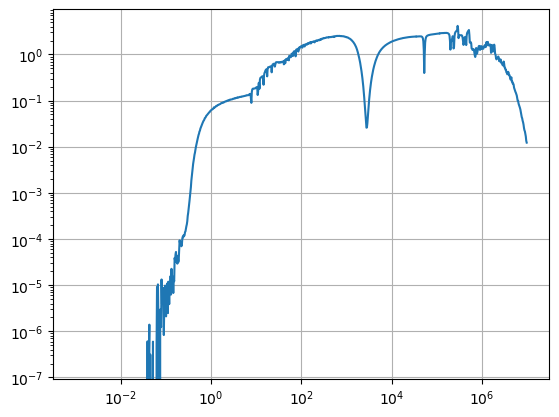

In [11]:
plt.loglog(energy_x,flux_vals);
plt.grid()

In [12]:
#import os
#data_path = os.environ.get('DATAPATH');
OMC_DATA = "/home/stu/OMC_DATA/endfb71_hdf5"

na_path = OMC_DATA + "/Na23.h5";

na23 = openmc.data.IncidentNeutron.from_hdf5(na_path);

In [13]:
type(na23)

openmc.data.neutron.IncidentNeutron

In [14]:
na23.energy

{'0K': array([1.00000e-05, 1.03125e-05, 1.06250e-05, ..., 1.90000e+07,
        1.99470e+07, 2.00000e+07]),
 '1200K': array([1.00000e-05, 1.03125e-05, 1.06250e-05, ..., 1.90000e+07,
        1.99470e+07, 2.00000e+07]),
 '2500K': array([1.00000e-05, 1.03125e-05, 1.06250e-05, ..., 1.90000e+07,
        1.99470e+07, 2.00000e+07]),
 '250K': array([1.00000e-05, 1.03125e-05, 1.06250e-05, ..., 1.90000e+07,
        1.99470e+07, 2.00000e+07]),
 '294K': array([1.00000e-05, 1.03125e-05, 1.06250e-05, ..., 1.90000e+07,
        1.99470e+07, 2.00000e+07]),
 '600K': array([1.00000e-05, 1.03125e-05, 1.06250e-05, ..., 1.90000e+07,
        1.99470e+07, 2.00000e+07]),
 '900K': array([1.00000e-05, 1.03125e-05, 1.06250e-05, ..., 1.90000e+07,
        1.99470e+07, 2.00000e+07])}

In [15]:
energies = na23.energy['600K'];

In [16]:
print(list(na23.reactions.values()))

[<Reaction: MT=2 (n,elastic)>, <Reaction: MT=3>, <Reaction: MT=16 (n,2n)>, <Reaction: MT=51 (n,n1)>, <Reaction: MT=52 (n,n2)>, <Reaction: MT=53 (n,n3)>, <Reaction: MT=54 (n,n4)>, <Reaction: MT=55 (n,n5)>, <Reaction: MT=56 (n,n6)>, <Reaction: MT=57 (n,n7)>, <Reaction: MT=58 (n,n8)>, <Reaction: MT=59 (n,n9)>, <Reaction: MT=60 (n,n10)>, <Reaction: MT=61 (n,n11)>, <Reaction: MT=62 (n,n12)>, <Reaction: MT=63 (n,n13)>, <Reaction: MT=64 (n,n14)>, <Reaction: MT=65 (n,n15)>, <Reaction: MT=66 (n,n16)>, <Reaction: MT=67 (n,n17)>, <Reaction: MT=68 (n,n18)>, <Reaction: MT=91 (n,nc)>, <Reaction: MT=102 (n,gamma)>, <Reaction: MT=103 (n,p)>, <Reaction: MT=107 (n,a)>, <Reaction: MT=203 (n,Xp)>, <Reaction: MT=207 (n,Xa)>, <Reaction: MT=301 heating>, <Reaction: MT=444 damage-energy>, <Reaction: MT=901 heating-local>]


In [17]:
na23_ngamma = na23[102];

In [18]:
pu_path = OMC_DATA + "/Pu239.h5";

pu239 = openmc.data.IncidentNeutron.from_hdf5(pu_path);

In [19]:
pu_energies = pu239.energy['600K'];

In [20]:
print(list(pu239.reactions.values()))

[<Reaction: MT=2 (n,elastic)>, <Reaction: MT=3>, <Reaction: MT=4 (n,level)>, <Reaction: MT=16 (n,2n)>, <Reaction: MT=17 (n,3n)>, <Reaction: MT=18 (n,fission)>, <Reaction: MT=37 (n,4n)>, <Reaction: MT=51 (n,n1)>, <Reaction: MT=52 (n,n2)>, <Reaction: MT=53 (n,n3)>, <Reaction: MT=54 (n,n4)>, <Reaction: MT=55 (n,n5)>, <Reaction: MT=56 (n,n6)>, <Reaction: MT=57 (n,n7)>, <Reaction: MT=58 (n,n8)>, <Reaction: MT=59 (n,n9)>, <Reaction: MT=60 (n,n10)>, <Reaction: MT=61 (n,n11)>, <Reaction: MT=62 (n,n12)>, <Reaction: MT=63 (n,n13)>, <Reaction: MT=64 (n,n14)>, <Reaction: MT=65 (n,n15)>, <Reaction: MT=66 (n,n16)>, <Reaction: MT=67 (n,n17)>, <Reaction: MT=68 (n,n18)>, <Reaction: MT=69 (n,n19)>, <Reaction: MT=70 (n,n20)>, <Reaction: MT=71 (n,n21)>, <Reaction: MT=72 (n,n22)>, <Reaction: MT=73 (n,n23)>, <Reaction: MT=74 (n,n24)>, <Reaction: MT=75 (n,n25)>, <Reaction: MT=76 (n,n26)>, <Reaction: MT=77 (n,n27)>, <Reaction: MT=78 (n,n28)>, <Reaction: MT=79 (n,n29)>, <Reaction: MT=80 (n,n30)>, <Reaction: MT

In [21]:
pu_fission = pu239[18]; 
pu_ngamma = pu239[102];

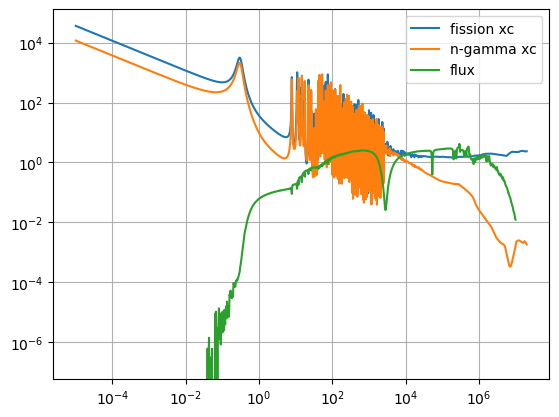

In [22]:
plt.loglog(pu_fission.xs['600K'].x,pu_fission.xs['600K'].y,label='fission xc');
plt.loglog(pu_ngamma.xs['600K'].x,pu_ngamma.xs['600K'].y,label='n-gamma xc');
plt.loglog(energy_x,flux_vals,label='flux');
plt.grid();
plt.legend();

Plot the flux spectrum and overlay the Na23 n-gamma xc.

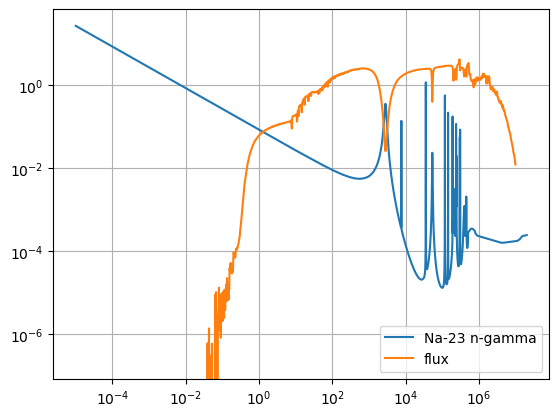

In [23]:
plt.loglog(na23_ngamma.xs['600K'].x,na23_ngamma.xs['600K'].y,label='Na-23 n-gamma');
plt.loglog(energy_x,flux_vals,label='flux');
plt.grid();
plt.legend();

plot the energies where the captures and fissions are happening

In [24]:
fiss_binned = sp.get_tally(name='fission binned');
fb_df = fiss_binned.get_pandas_dataframe();
fiss_values = fb_df['mean'].to_numpy();

ng_binned = sp.get_tally(name='n_gamma binned');
ng_df = ng_binned.get_pandas_dataframe();
ng_values = ng_df['mean'].to_numpy();

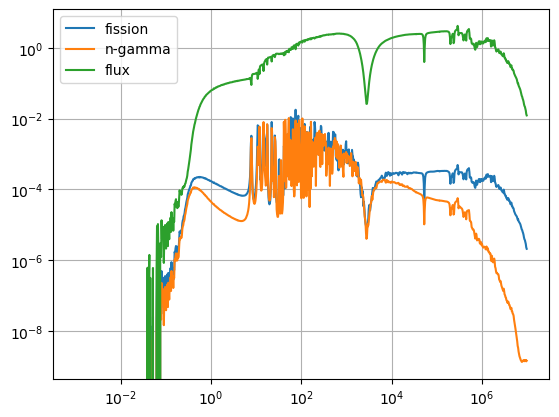

In [26]:
plt.loglog(energy_x,fiss_values,label='fission');
plt.loglog(energy_x,ng_values,label='n-gamma');
plt.loglog(energy_x,flux_vals,label='flux');
plt.grid();
plt.legend();

It *looks* as if most of the reactions are happening in the resonance region where the fission and capture cross sections are comparable. Fission is only the most probable reaction because of the high-energy fissions where the capture xc is relatively low.

To the best of my ability to determine, the homogeneous Pu-Na mixture bears no significant resemblance to the sorts of cores on which the nominal 1-group data are based.  

In order to make a different comparison I want to construct a heterogeneous Pu-Na core with the same weight percent of each component.  Obviously, all of the materials included will be in physically unrealisitic states but it will be something to work with.
